# Trees!

Oftentimes, we don't want to just settle for flat representations of our dataset, we would also like to learn heirarchical structure as part of the inc 

In [2]:
!pip install git+https://www.github.com/jhaberbe/chinese_restaurant_process --quiet

In [ ]:
import numpy as np
from crp.table import ChineseRestaurantTable, DirichletMultinomialTable, NegativeBinomialTable
from crp.nested import ChineseRestaurantProcessNode

In [1]:
import numpy as np
import scanpy as sc

adata = sc.read_h5ad("/Users/jameshaberberger/GitHub/choroid-plexus/new_annotations.h5ad")
adata = adata[adata.obs["Cell.Subtype"].ne("Doublet")]
sc.pp.highly_variable_genes(adata, flavor="seurat_v3")
adata = adata[adata.X.sum(axis=1) > 300, adata.var["highly_variable"]]

/Users/jameshaberberger/GitHub/chinese_restaurant_process/.venv/lib/python3.13/site-packages/scanpy/preprocessing/_highly_variable_genes.py:172: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


In [4]:
counts = adata.X.todense()[:, adata.var["highly_variable"]]
size_factors = np.log(counts.sum(axis=1) / counts.sum(axis=1).mean())

### Transforming our Tables into Nodes

In [ ]:
import numpy as np
from tqdm import trange, tqdm

class ChineseRestaurantProcessNode:
    def __init__(
            self, 
            data, 
            table_class: ChineseRestaurantTable, 
            parent = None, 
            depth: int = 0,
            expected_number_of_classes: int = 1
        ):
        # Setup data.
        self.data = data
        self.table_class = table_class
        self.table = self.table_class(data)

        # Setup tree structure.
        self.depth = depth
        self.parent = parent
        self.children = {}
        self.members = set()

        # Setup infernce machinery.
        self.expected_number_of_classes = expected_number_of_classes
        self.alpha = expected_number_of_classes / np.log(self.data.shape[0])

    def add_child(self, data):
        # Create a new child node with the given data.
        child = ChineseRestaurantProcessNode(
            data,
            depth=self.depth + 1,
            parent=self,
            table_class=self.table_class,
            expected_number_of_classes = self.expected_number_of_classes
        )

        # Find the next available slot for the child.
        i = 0
        while i in self.children:
            i+=1

        # Add the child to the children dictionary.
        self.children[i] = child

        # Return the newly created child node.
        return child

    def add_member(self, index):
        self.members.add(index)
        self.table.add_member(index)

    def remove_member(self, index):
        self.members.discard(index)
        self.table.remove_member(index)
    
    def has_member(self, index):
        return index in self.members
    
    @staticmethod
    def sample_path(node, index, depth=0, max_depth=4, scale_factor = 2.0):
        node.add_member(index)
        existing_children = list(node.children.items())
        log_posteriors = []

        # Score existing children
        for child_key, child_node in existing_children:
            ll = child_node.table.log_likelihood(index, posterior=True)
            prior = np.log1p(len(child_node.members))  # prior favors larger children
            log_posteriors.append(ll + prior)

        # Score new child
        new_child = ChineseRestaurantProcessNode(
            node.table.data,
            depth = node.depth + 1,
            parent = node,
            table_class = node.table_class,
            expected_number_of_classes = node.expected_number_of_classes * scale_factor
        )

        # Log likelihood of the new child
        ll_new = new_child.table.log_likelihood(index, posterior=True)
        prior_new = np.log(node.alpha if hasattr(node, 'alpha') else 1.0)  # Use alpha if set, else 1.0
        log_posteriors.append(ll_new + prior_new)

        # Normalize and sample
        log_posteriors = np.array(log_posteriors)
        max_log = np.max(log_posteriors)
        probs = np.exp(log_posteriors - max_log)
        probs /= probs.sum()

        choice = np.random.choice(len(probs), p=probs)

        if choice == len(existing_children):
            # Create and add new child
            new_key = 0
            while new_key in node.children:
                new_key += 1
            node.children[new_key] = new_child
            return [new_key]

        else:
            child_key = existing_children[choice][0]
            if depth + 1 < max_depth:
                # Recurse down the chosen child node
                path = ChineseRestaurantProcessNode.sample_path(
                    node.children[child_key],
                    index,
                    depth = depth + 1,
                    max_depth = max_depth
                )
                return [child_key] + path
            else:
                # At max depth, add member to this node and return path
                node.children[child_key].add_member(index)
                return [child_key]

    def predict_paths(root, count_matrix, max_depth=4):
        """
        For each row in the count_matrix, traverse the tree from root,
        selecting the most likely child at each level, returning the path.

        Returns:
            paths: list of lists of keys, one per sample.
        """
        paths = []
        for index in trange(count_matrix.shape[0]):
            node = root
            path = []
            depth = 0

            while depth < max_depth and node.children:
                best_key = None
                best_score = -np.inf

                for key, child in node.children.items():
                    ll = child.table.log_likelihood(index, posterior=True)
                    prior = np.log1p(len(child.members))  # favor larger clusters
                    score = ll + prior
                    if score > best_score:
                        best_score = score
                        best_key = key

                if best_key is None:
                    break  # no children

                path.append(best_key)
                node = node.children[best_key]
                depth += 1

            paths.append(path)

        return paths


In [12]:
X = np.array(counts[::10])

In [13]:
root = ChineseRestaurantProcessNode(X, table_class=NegativeBinomialTable, expected_number_of_classes = 2)
for idx in trange(X.shape[0]):
    # Optionally remove idx from current assignments if doing iterative inference
    path = ChineseRestaurantProcessNode.sample_path(root, idx, max_depth=3)

100%|██████████| 18194/18194 [09:00<00:00, 33.64it/s]


In [16]:
labels = root.predict_paths(np.array(X[:, adata.var.highly_variable]))

100%|██████████| 18194/18194 [01:41<00:00, 179.68it/s]


<Axes: >

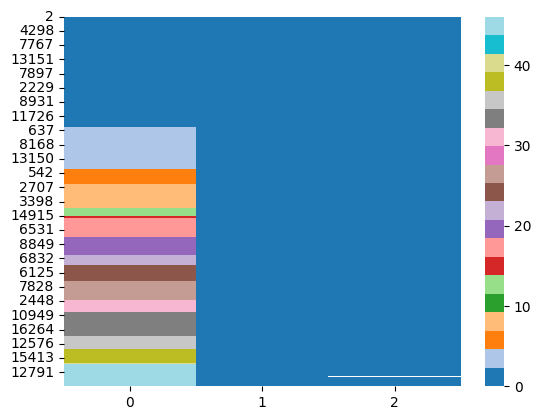

In [20]:
import pandas as pd
import seaborn as sns
sns.heatmap(pd.DataFrame(labels).sort_values(by=[0, 1, 2]), cmap='tab20')

In [24]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from collections import defaultdict

def build_sankey_data(root):
    label_to_index = {}
    label_depths = {}
    source = []
    target = []
    value = []
    labels = []
    counter = [0]

    def get_label(node):
        label = f"Depth{node.depth}_Node{id(node)}"
        if label not in label_to_index:
            label_to_index[label] = counter[0]
            labels.append(label)
            label_depths[label] = node.depth
            counter[0] += 1
        return label

    def traverse(node):
        parent_label = get_label(node)
        for key, child in node.children.items():
            child_label = get_label(child)
            source.append(label_to_index[parent_label])
            target.append(label_to_index[child_label])
            value.append(len(child.members))
            traverse(child)

    traverse(root)
    return source, target, value, labels, label_depths


In [31]:
def plot_sankey(source, target, value, labels, label_depths, height=600):
    # Use a colormap (e.g., tab20) to assign colors by depth
    unique_depths = sorted(set(label_depths.values()))
    cmap = plt.get_cmap('tab20')
    depth_colors = {d: mcolors.to_hex(cmap(i % 20)) for i, d in enumerate(unique_depths)}
    
    node_colors = [depth_colors[label_depths[label]] for label in labels]

    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels,
            color=node_colors
        ),
        link=dict(
            source=source,
            target=target,
            value=value
        ))])

    fig.update_layout(
        title_text="nCRP Sample Flow Sankey Diagram",
        font_size=10,
        height=height
    )
    fig.show()


plot_sankey(*build_sankey_data(root), height=4000)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [33]:
subset = adata[::10]
sc.pp.normalize_total(subset)
sc.pp.log1p(subset)
sc.pp.pca(subset)
sc.pp.neighbors(subset)
sc.tl.umap(subset)

/Users/jameshaberberger/GitHub/chinese_restaurant_process/.venv/lib/python3.13/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning:

Received a view of an AnnData. Making a copy.

/Users/jameshaberberger/GitHub/chinese_restaurant_process/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



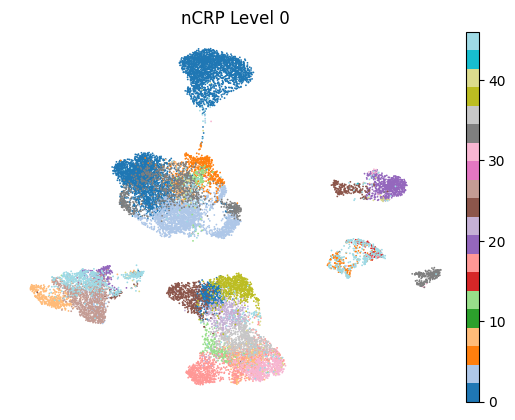

In [37]:
subset.obs["ncrp_level_0"] = [x[0] for x in labels]
sc.pl.umap(subset, color=["ncrp_level_0"], cmap="tab20", legend_loc="on data", frameon=False, title="nCRP Level 0")

# Current Proposed `nested.py`

In [ ]:
import numpy as np
from tqdm import trange, tqdm
from .table import ChineseRestaurantTable, DirichletMultinomialTable, NegativeBinomialTable

class ChineseRestaurantProcessNode:
    def __init__(
            self, 
            data, 
            table_class: ChineseRestaurantTable, 
            parent = None, 
            depth: int = 0,
            expected_number_of_classes: int = 1
        ):
        # Setup data.
        self.data = data
        self.table_class = table_class
        self.table = self.table_class(data)

        # Setup tree structure.
        self.depth = depth
        self.parent = parent
        self.children = {}
        self.members = set()

        # Setup infernce machinery.
        self.expected_number_of_classes = expected_number_of_classes
        self.alpha = expected_number_of_classes / np.log(self.data.shape[0])

    def add_child(self, data, scale_factor: int = 2):
        # Create a new child node with the given data.
        child = ChineseRestaurantProcessNode(
            data,
            depth=self.depth + 1,
            parent=self,
            table_class=self.table_class,
            expected_number_of_classes = self.expected_number_of_classes * scale_factor
        )

        # Find the next available slot for the child.
        i = 0
        while i in self.children:
            i+=1

        # Add the child to the children dictionary.
        self.children[i] = child

        # Return the newly created child node.
        return child

    def add_member(self, index):
        self.members.add(index)
        self.table.add_member(index)

    def remove_member(self, index):
        self.members.discard(index)
        self.table.remove_member(index)
    
    def has_member(self, index):
        return index in self.members
    
    @staticmethod
    def sample_path(node, index, depth=0, max_depth=4):
        node.add_member(index)
        existing_children = list(node.children.items())
        log_posteriors = []

        # Score existing children
        for child_key, child_node in existing_children:
            ll = child_node.table.log_likelihood(index, posterior=True)
            prior = np.log1p(len(child_node.members))  # prior favors larger children
            log_posteriors.append(ll + prior)

        # Score new child
        new_child = ChineseRestaurantProcessNode(
            node.table.data,
            depth = node.depth + 1,
            parent = node,
            table_class = node.table_class,
            expected_number_of_classes = node.expected_number_of_classes
        )

        # Log likelihood of the new child
        ll_new = new_child.table.log_likelihood(index, posterior=True)
        prior_new = np.log(node.alpha if hasattr(node, 'alpha') else 1.0)  # Use alpha if set, else 1.0
        log_posteriors.append(ll_new + prior_new)

        # Normalize and sample
        log_posteriors = np.array(log_posteriors)
        max_log = np.max(log_posteriors)
        probs = np.exp(log_posteriors - max_log)
        probs /= probs.sum()

        choice = np.random.choice(len(probs), p=probs)

        if choice == len(existing_children):
            # Create and add new child
            new_key = 0
            while new_key in node.children:
                new_key += 1
            node.children[new_key] = new_child
            return [new_key]

        else:
            child_key = existing_children[choice][0]
            if depth + 1 < max_depth:
                # Recurse down the chosen child node
                path = ChineseRestaurantProcessNode.sample_path(
                    node.children[child_key],
                    index,
                    depth = depth + 1,
                    max_depth = max_depth
                )
                return [child_key] + path
            else:
                # At max depth, add member to this node and return path
                node.children[child_key].add_member(index)
                return [child_key]

    def predict_paths(root, count_matrix, max_depth=4):
        """
        For each row in the count_matrix, traverse the tree from root,
        selecting the most likely child at each level, returning the path.

        Returns:
            paths: list of lists of keys, one per sample.
        """
        paths = []
        for index in trange(count_matrix.shape[0]):
            node = root
            path = []
            depth = 0

            while depth < max_depth and node.children:
                best_key = None
                best_score = -np.inf

                for key, child in node.children.items():
                    ll = child.table.log_likelihood(index, posterior=True)
                    prior = np.log1p(len(child.members))  # favor larger clusters
                    score = ll + prior
                    if score > best_score:
                        best_score = score
                        best_key = key

                if best_key is None:
                    break  # no children

                path.append(best_key)
                node = node.children[best_key]
                depth += 1

            paths.append(path)

        return paths

    def run(self, epochs = 1, max_depth = 4):
        for _ in range(epochs):
            for index in trange(self.data.shape[0]):
                path = ChineseRestaurantProcessNode.sample_path(self, index, max_depth = max_depth)